In [1]:
import pandas as pd

#### Загружаем резултаты трех компонент

In [173]:
topmine_df = pd.read_csv('./Data/Component_Results/topmine/topmine.csv', sep='\t')

In [174]:
topmine_df.head(3)

,ngramm,freq,score
0,machine learn,279.0,16.466273
1,kernel embedding,19.0,4.345288
2,distribution also,1.0,0.036855


---

In [175]:
syntaxnet_df = pd.read_csv('./Data/Component_Results/syntaxnet/syntaxnet.tsv', sep='\t')

In [176]:
syntaxnet_df.head(3)

,collocation,syntax_distance
0,machine learn,1.973783
1,kernel embedding,2.437500
2,distribution also,4.000000


---

In [177]:
bigartm_df = pd.read_csv('./Data/Component_Results/bigartm/bigartm.csv', sep='\t')

In [178]:
bigartm_df = bigartm_df.rename(columns={'ngramm': 'ngramm_bigartm'})

In [179]:
bigartm_df.head(3)

,ngramm_bigartm,kl_div,js_div,deg
0,machine learn,0.058956,0.015016,0.111636
1,kernel embedding,2.302585,0.525597,1.000000
2,distribution also,2.302585,0.525597,1.000000


Смотрим на размеры

In [180]:
topmine_df.shape

(29722, 3)

In [181]:
syntaxnet_df.shape

(29722, 2)

In [182]:
bigartm_df.shape  # Fffuuuuuu

(20065, 4)

---

Костыльно выкидываем все, что не попало в бигартм

In [183]:
topmine_df = topmine_df[topmine_df['ngramm'].isin(bigartm_df['ngramm_bigartm'])]

In [184]:
syntaxnet_df = syntaxnet_df[syntaxnet_df['collocation'].isin(bigartm_df['ngramm_bigartm'])]

---

Конкатенируем, перемешиваем, подключаем википедиевские коллокации и метим term/non term

In [188]:
X = pd.concat([topmine_df, syntaxnet_df, bigartm_df], axis=1)

In [189]:
X = X[X.columns[[0, 1, 2, 4, 6, 7, 8]]]

In [190]:
X = X.dropna()

In [191]:
X = X.sample(frac=1).reset_index(drop=True)

---

In [195]:
with open('./Data/Input/gt_collocs.txt') as f:
    gt_collocs = f.read().split('\n')

Забыл пролемматизировать википедиевские нграммы

In [196]:
from nltk.stem.wordnet import WordNetLemmatizer

In [197]:
lemmatizer = WordNetLemmatizer()

In [198]:
new_gt_collocs = []
for colloc in gt_collocs:
    new_gt_colloc = []
    for word in colloc.split(' '):
        new_gt_colloc.append(lemmatizer.lemmatize(word))
    new_gt_collocs.append(' '.join(new_gt_colloc))

In [199]:
intersect = []
labels = []
for row in tqdm(X.itertuples(), total=len(X)):
    if row.ngramm in new_gt_collocs:
        intersect.append(row.ngramm)
        labels.append(1)
    else:
        labels.append(0)

100%|██████████| 9547/9547 [00:00<00:00, 19874.27it/s]


In [203]:
X['label'] = labels

In [201]:
len(new_gt_collocs)  # сколько википедиевских

3651

In [202]:
len(X)  # сколько кандидатов

9547

In [200]:
len(intersect)  # пересечение википедиевских нграмм и кандидатов

530

---

Разбиваем на train/validation <br>
train: 350 \* 2 = 700
validation: 150 \* 2 = 300

In [204]:
train_true_counter = 0
train_false_counter = 0
val_true_counter = 0
val_false_counter = 0


train_inds = []
val_inds = []

train_true_flag = True
train_false_flag = True
for row in X.itertuples():
    if row.label == 0 and train_false_counter <= 350 and train_false_flag:
        train_inds.append(row.Index)
        train_false_counter += 1
    elif row.label == 1 and train_true_counter <= 350 and train_true_flag:
        train_inds.append(row.Index)
        train_true_counter += 1
    elif row.label == 0 and val_false_counter <= 150:
        val_inds.append(row.Index)
        val_false_counter += 1
    elif row.label == 1 and val_true_counter <= 150:
        val_inds.append(row.Index)
        val_true_counter += 1
        
    if train_false_counter > 350:
        train_false_flag = False
    if train_true_counter > 350:
        train_true_flag = False

In [205]:
X_train = X.loc[train_inds]
X_val = X.loc[val_inds]
y_train = X_train['label'].values
y_val = X_val['label'].values

In [206]:
X_train = X_train[X_train.columns[1:-1]]
X_val = X_val[X_val.columns[1:-1]]

---

Обучаем модель

In [146]:
from sklearn.linear_model import LogisticRegression

In [147]:
clf = LogisticRegression()

In [148]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [149]:
y_test = clf.predict(X_val)

In [152]:
(y_test == y_val).sum() / len(y_val)  # accuracy

0.7516556291390728

In [163]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

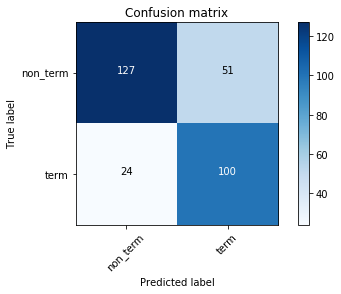

In [167]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_val)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_term', 'term'],
                      title='Confusion matrix')

In [168]:
TP = ((y_test == 1) * (y_val == 1)).sum()
TN = ((y_test == 0) * (y_val == 0)).sum()
FN = ((y_test == 1) * (y_val == 0)).sum()
FP = ((y_test == 0) * (y_val == 1)).sum()

In [170]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [172]:
print('precision:\t{}'.format(precision))
print('recall:\t\t{}'.format(recall))

precision:	0.6622516556291391
recall:		0.8064516129032258


---